In [ ]:
!gdown 1-Fz1Bo_oBpzsop8buB7NbDhCqqIpixEl

Downloading...
From: https://drive.google.com/uc?id=1-Fz1Bo_oBpzsop8buB7NbDhCqqIpixEl
To: /content/kidStn512_aux.rar
100% 223M/223M [00:01<00:00, 219MB/s]


In [ ]:
!unrar x "/content/kidStn512_aux.rar"

Se han truncado las últimas 5000 líneas del flujo de salida.
Extracting  kidStn512_aux/images/ct246_image84.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct246_image85.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct246_image86.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct246_image87.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct246_image88.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct246_image92.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct246_image96.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct247_image100.jpg                       95%  OK 
Extracting  kidStn512_aux/images/ct247_image101.jpg                       95%  OK 
Extracting  kidStn512_aux/images/ct247_image107.jpg                       95%  OK 
Extracting  kidStn5

In [ ]:
import numpy as np
import nibabel as nib
import glob
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tifffile import imsave
from PIL import Image
import cv2
from tensorflow import keras
from tensorflow.keras.utils import normalize
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, TensorBoard
import datetime, os

In [ ]:
#imagesList = os.listdir("/content/kidStn512_aux/images")
#num_images = len(imagesList)
num_images = 4000
n_classes = 3
print(num_images)

4000


In [ ]:
image_names = glob.glob("/content/kidStn512_aux/images/*.jpg")
image_names.sort()
image_names_subset = image_names[0:num_images]
images=[]
for image in image_names_subset:
  img = cv2.imread(image, 0)
  redim1 = cv2.resize(img, (256,256))
  images.append(redim1)
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)
image_dataset = image_dataset /255.

In [ ]:
mask_names = glob.glob("/content/kidStn512_aux/masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks=[]
for mask in mask_names_subset:
  msk = cv2.imread(mask, 0)
  redim2 = cv2.resize(msk, (256,256))
  masks.append(redim2)
mask_dataset = np.array(masks)

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (4000, 256, 256, 1)
Mask data shape is:  (4000, 256, 256)
Max pixel value in image is:  1.0
Labels in the mask are :  [0 1 2]


In [ ]:
'''
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)
'''

'\nfrom sklearn.preprocessing import LabelEncoder\nlabelencoder = LabelEncoder()\nn, h, w = mask_dataset.shape\nmask_dataset_reshaped = mask_dataset.reshape(-1,1)\nmask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)\nmask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)\n\nnp.unique(mask_dataset_encoded)\n'

In [ ]:
#mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)
print(mask_dataset_encoded.shape)

(4000, 256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
#MultiResUnet

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model
def conv_block(x, num_filters, kernel_size, padding="same", act=True):
    x = Conv2D(num_filters, kernel_size, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    if act:
        x = Activation("relu")(x)
    return x

def multires_block(x, num_filters, alpha=1.67):
    W = num_filters * alpha

    x0 = x
    x1 = conv_block(x0, int(W*0.167), 3)
    x2 = conv_block(x1, int(W*0.333), 3)
    x3 = conv_block(x2, int(W*0.5), 3)
    xc = Concatenate()([x1, x2, x3])
    xc = BatchNormalization()(xc)

    nf = int(W*0.167) + int(W*0.333) + int(W*0.5)
    sc = conv_block(x0, nf, 1, act=False)

    x = Activation("relu")(xc + sc)
    x = BatchNormalization()(x)
    return x

def res_path(x, num_filters, length):
    for i in range(length):
        x0 = x
        x1 = conv_block(x0, num_filters, 3, act=False)
        sc = conv_block(x0, num_filters, 1, act=False)
        x = Activation("relu")(x1 + sc)
        x = BatchNormalization()(x)
    return x

def encoder_block(x, num_filters, length):
    x = multires_block(x, num_filters)
    s = res_path(x, num_filters, length)
    p = MaxPooling2D((2, 2))(x)
    return s, p

def decoder_block(x, skip, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(x)
    x = Concatenate()([x, skip])
    x = multires_block(x, num_filters)
    return x
class MultiResunet:
  def __init__(self, input_size=256):
        self.input_size = input_size

  def build_model(self):
      #Input
      inputs = Input((self.input_size, self.input_size, 1))

      #Encoder
      p0 = inputs
      s1, p1 = encoder_block(p0, 16, 4)
      s2, p2 = encoder_block(p1, 32, 3)
      s3, p3 = encoder_block(p2, 64, 2)
      s4, p4 = encoder_block(p3, 128, 1)

      #Bridge
      b1 = multires_block(p4, 256)

      #Decoder
      d1 = decoder_block(b1, s4, 128)
      d2 = decoder_block(d1, s3, 64)
      d3 = decoder_block(d2, s2, 32)
      d4 = decoder_block(d3, s1, 16)

      #Output
      outputs = Conv2D(3, 1, padding="same", activation="softmax")(d4)

      #Model
      model = Model(inputs, outputs)

      return model

In [ ]:
## MultiResUNet
arch = MultiResunet(input_size=256)
model = arch.build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 4)  36          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 4)  16         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = TensorBoard(logdir, histogram_freq=1)
#tensorboard = TensorBoard(log_dir="logs1/{}".format(time()))
csv_logger = CSVLogger('resultsMultiResunet.log', separator=",", append=False)
log = model.fit(X_train, y_train_cat, batch_size=16, epochs=15, validation_data=(X_test, y_test_cat), shuffle=False, callbacks=[csv_logger])

Epoch 1/15
200/200 [==============================] - 92s 181ms/step - loss: 0.4486 - accuracy: 0.9456 - val_loss: 0.2142 - val_accuracy: 0.9684
Epoch 2/15
200/200 [==============================] - 33s 167ms/step - loss: 0.0462 - accuracy: 0.9947 - val_loss: 0.1751 - val_accuracy: 0.9698
Epoch 3/15
200/200 [==============================] - 33s 167ms/step - loss: 0.0246 - accuracy: 0.9952 - val_loss: 0.0362 - val_accuracy: 0.9928
Epoch 4/15
200/200 [==============================] - 33s 167ms/step - loss: 0.0176 - accuracy: 0.9956 - val_loss: 0.0154 - val_accuracy: 0.9955
Epoch 5/15
200/200 [==============================] - 33s 167ms/step - loss: 0.0123 - accuracy: 0.9964 - val_loss: 0.0122 - val_accuracy: 0.9963
Epoch 6/15
200/200 [==============================] - 33s 166ms/step - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.0112 - val_accuracy: 0.9964
Epoch 7/15
200/200 [==============================] - 33s 167ms/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 0.0101 - val_ac

In [ ]:
#Guardar modelo
model.save('MultiResunet.hdf5')

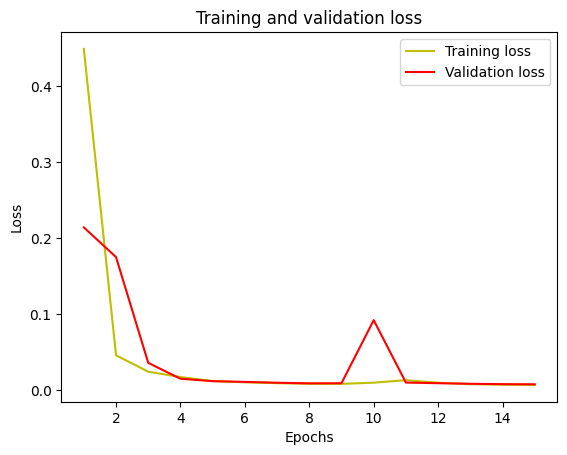

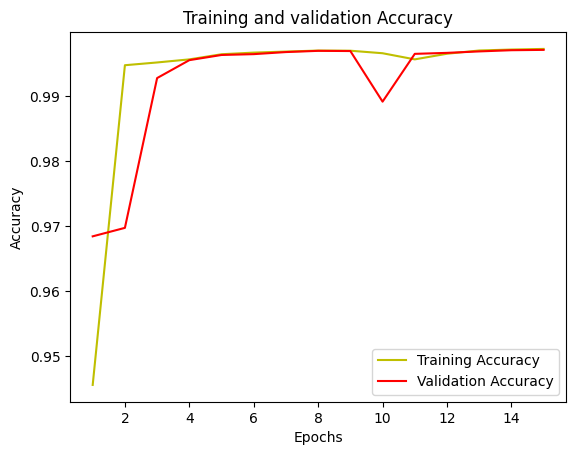

In [ ]:
#Loss y Accuracy
loss = log.history['loss']
val_loss = log.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = log.history['accuracy']
val_acc = log.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model("MultiResunet.hdf5", compile=False)

In [ ]:
y_pred=model.predict(X_test)

25/25 [==============================] - 4s 50ms/step


In [ ]:
y_pred.shape

(800, 256, 256, 3)

In [ ]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(800, 256, 256)

In [ ]:
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7898329


In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)

[[1.6777216e+07 9.5030000e+03 2.0050000e+04]
 [4.3608000e+04 7.9652000e+04 3.5119000e+04]
 [3.2004000e+04 1.2059000e+04 1.3834330e+06]]
IoU for class1 is:  0.99377066
IoU for class2 is:  0.4426562
IoU for class3 is:  0.93307185


1/1 [==============================] - 2s 2s/step


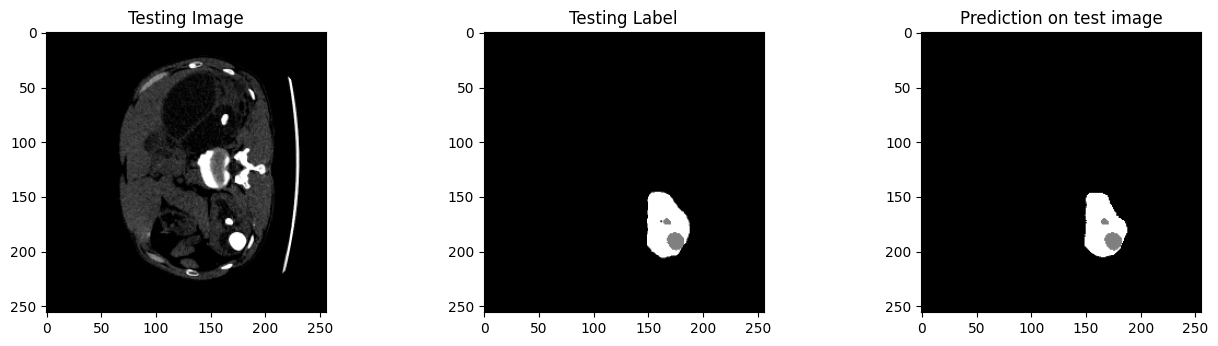

In [ ]:
#Predicciones
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()

1/1 [==============================] - 0s 26ms/step


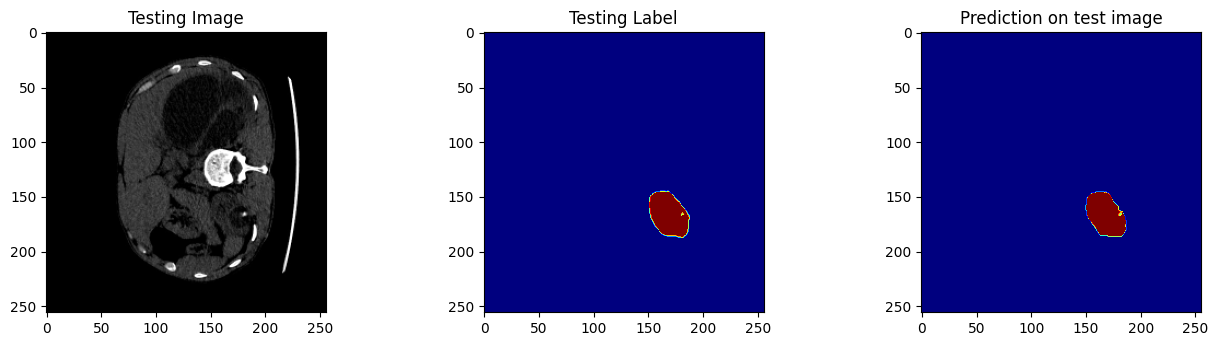

In [ ]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()